In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pydot
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from tensorflow.keras.utils import plot_model

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

In [5]:
df = pd.read_csv('/content/drive/MyDrive/file.csv')

In [6]:
len(df)

219294

In [7]:
df=df.head(12000)
df.shape

(12000, 3)

In [8]:
df = df[['tweets', 'labels']]

In [9]:
# Remove all the tweet links since they all begin with https:

df['tweet_list'] = df['tweets'].str.split('https:')

In [10]:
# Select the text part of the list

text = [i[0] for i in df.tweet_list]

In [11]:
df['text'] = text

In [12]:
df = df[['text', 'labels']]

In [13]:
# Import re for string processing

import re

In [14]:
# Remove all non-alphanumeric characters from the text list

string = r'[A-Za-z0-9 ]'

trim_list=[]

for row in text:
    s=''
    for letter in row:
        if bool(re.match(string, letter)):
            s+=letter
    trim_list.append(s)

In [19]:
# Remove the non-printing characters from text

rep_list = ['\U0001fae1', '\\n', '@', '#', '\xa0', '***']

for i in trim_list:
    for j in rep_list:
        if j in i:
            i.replace(j,'')

In [20]:
df['text'] = trim_list

In [21]:
# Map the labels to integers
# 1 for good tweet
# 0 for neutral tweet
# -1 for bad tweet

df['lab_int'] = np.where(df['labels']=='good', 1, np.where(df['labels']=='bad', -1, 0))
df.lab_int

0        0
1        1
2        0
3        1
4       -1
        ..
11995    1
11996   -1
11997    0
11998   -1
11999   -1
Name: lab_int, Length: 12000, dtype: int64

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from sklearn.metrics import classification_report

In [23]:
# 텍스트 데이터를 정수로 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
encoded_texts = tokenizer.texts_to_sequences(df.text)

In [24]:
# 시퀀스 패딩
max_length = max([len(text.split()) for text in df.text])  # 시퀀스의 최대 길이
padded_texts = pad_sequences(encoded_texts, maxlen=max_length, padding='post')


In [25]:
# 삼진 분류를 위해 레이블을 One-hot 인코딩
num_classes = len(set(df.lab_int))
one_hot_labels = tf.keras.utils.to_categorical(df.lab_int, num_classes)

In [26]:
# 데이터를 train과 test로 나누기
split_ratio = 0.8  # train 데이터의 비율
split_index = int(len(padded_texts) * split_ratio)

train_texts = padded_texts[:split_index]
train_labels = one_hot_labels[:split_index]

test_texts = padded_texts[split_index:]
test_labels = one_hot_labels[split_index:]


In [ ]:
# RNN 모델 구축
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_length))
model.add(SimpleRNN(64))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 100)           2058600   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                10560     
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2,069,355
Trainable params: 2,069,355
Non-trainable params: 0
_________________________________________________________________


In [ ]:
)

AttributeError: ignored

In [ ]:
# 모델 훈련
history = model.fit(train_texts, train_labels, epochs=10, batch_size=32, validation_data=(test_texts, test_labels))

Epoch 1/10
300/300 [==============================] - 18s 54ms/step - loss: 1.0621 - accuracy: 0.4710 - val_loss: 1.0741 - val_accuracy: 0.4500
Epoch 2/10
300/300 [==============================] - 14s 48ms/step - loss: 1.0336 - accuracy: 0.4835 - val_loss: 1.0802 - val_accuracy: 0.4654
Epoch 3/10
300/300 [==============================] - 17s 56ms/step - loss: 0.9334 - accuracy: 0.5686 - val_loss: 1.1369 - val_accuracy: 0.4338
Epoch 4/10
300/300 [==============================] - 14s 48ms/step - loss: 0.7433 - accuracy: 0.6953 - val_loss: 1.0899 - val_accuracy: 0.4692
Epoch 5/10
300/300 [==============================] - 15s 48ms/step - loss: 0.5365 - accuracy: 0.7919 - val_loss: 1.2796 - val_accuracy: 0.4900
Epoch 6/10
300/300 [==============================] - 15s 50ms/step - loss: 0.3582 - accuracy: 0.8664 - val_loss: 1.5188 - val_accuracy: 0.4712
Epoch 7/10
300/300 [==============================] - 14s 48ms/step - loss: 0.2629 - accuracy: 0.9094 - val_loss: 1.4455 - val_accuracy:

In [ ]:
# 테스트 데이터로 성능 측정
predictions = model.predict(test_texts)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(test_labels, axis=1)

print(classification_report(true_labels, predicted_labels))

75/75 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.31      0.39      0.35       587
           1       0.52      0.38      0.44       733
           2       0.60      0.63      0.61      1080

    accuracy                           0.49      2400
   macro avg       0.48      0.47      0.47      2400
weighted avg       0.51      0.49      0.50      2400



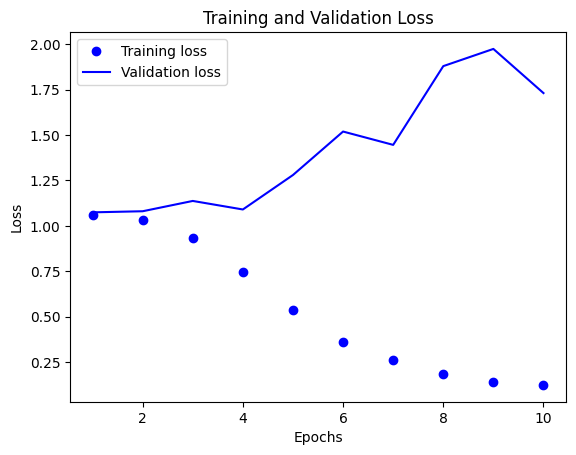

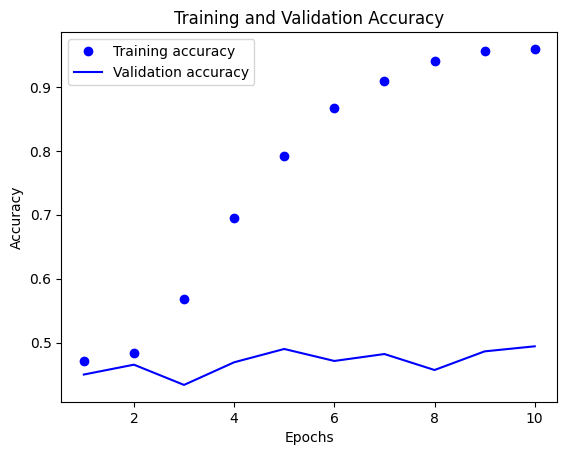

In [ ]:
# Epoch별 train data와 test data의 loss와 accuracy 그래프 그리기
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, train_accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
from tensorflow.keras.layers import Bidirectional

# RNN 모델 구축
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_length))
model.add(Bidirectional(SimpleRNN(64, return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 100)           2058600   
                                                                 
 bidirectional (Bidirectiona  (None, 60, 128)          21120     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              24704     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 2,104,811
Trainable params: 2,104,811
Non-

In [28]:
# 모델 훈련
history = model.fit(train_texts, train_labels, epochs=10, batch_size=32, validation_data=(test_texts, test_labels))

Epoch 1/10
300/300 [==============================] - 40s 112ms/step - loss: 0.9441 - accuracy: 0.5654 - val_loss: 0.8724 - val_accuracy: 0.6200
Epoch 2/10
300/300 [==============================] - 33s 109ms/step - loss: 0.4637 - accuracy: 0.8209 - val_loss: 0.9176 - val_accuracy: 0.6367
Epoch 3/10
300/300 [==============================] - 35s 116ms/step - loss: 0.1255 - accuracy: 0.9639 - val_loss: 1.0945 - val_accuracy: 0.6587
Epoch 4/10
300/300 [==============================] - 32s 108ms/step - loss: 0.0515 - accuracy: 0.9867 - val_loss: 1.2985 - val_accuracy: 0.6288
Epoch 5/10
300/300 [==============================] - 33s 110ms/step - loss: 0.0323 - accuracy: 0.9915 - val_loss: 1.4584 - val_accuracy: 0.6388
Epoch 6/10
300/300 [==============================] - 35s 116ms/step - loss: 0.0384 - accuracy: 0.9877 - val_loss: 1.6716 - val_accuracy: 0.6467
Epoch 7/10
300/300 [==============================] - 33s 110ms/step - loss: 0.0729 - accuracy: 0.9774 - val_loss: 1.5510 - val_ac

In [29]:
# 테스트 데이터로 성능 측정
predictions = model.predict(test_texts)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(test_labels, axis=1)

print(classification_report(true_labels, predicted_labels))

75/75 [==============================] - 3s 25ms/step
              precision    recall  f1-score   support

           0       0.42      0.38      0.40       587
           1       0.68      0.65      0.67       733
           2       0.73      0.78      0.76      1080

    accuracy                           0.64      2400
   macro avg       0.61      0.61      0.61      2400
weighted avg       0.64      0.64      0.64      2400



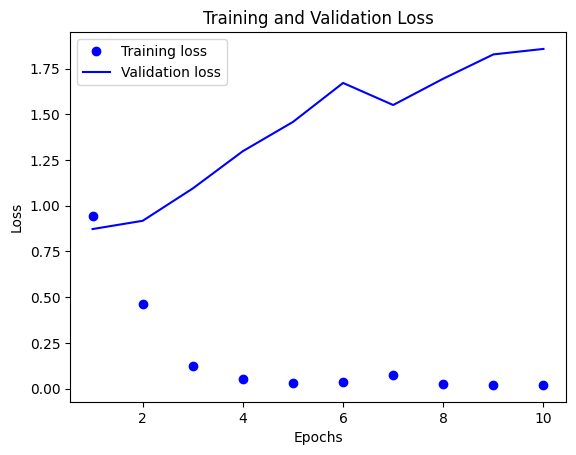

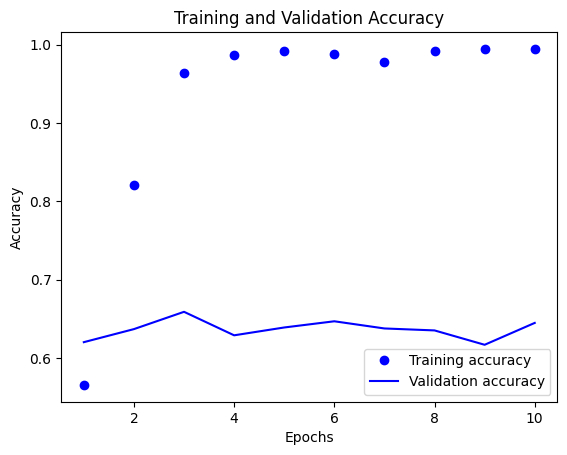

In [31]:
# Epoch별 train data와 test data의 loss와 accuracy 그래프 그리기
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, train_accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
from tensorflow.keras.layers import LSTM

# LSTM 모델 구축
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_length))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 100)           2058600   
                                                                 
 bidirectional_2 (Bidirectio  (None, 60, 256)          234496    
 nal)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,490,603
Trainable params: 2,490,603
Non-trainable params: 0
____________________________________________

In [33]:
# 모델 훈련
history = model.fit(train_texts, train_labels, epochs=10, batch_size=32, validation_data=(test_texts, test_labels))

Epoch 1/10
300/300 [==============================] - 128s 403ms/step - loss: 0.9177 - accuracy: 0.5785 - val_loss: 0.7052 - val_accuracy: 0.7108
Epoch 2/10
300/300 [==============================] - 119s 396ms/step - loss: 0.5621 - accuracy: 0.7845 - val_loss: 0.7298 - val_accuracy: 0.6896
Epoch 3/10
300/300 [==============================] - 117s 390ms/step - loss: 0.3805 - accuracy: 0.8682 - val_loss: 0.7421 - val_accuracy: 0.7071
Epoch 4/10
300/300 [==============================] - 121s 403ms/step - loss: 0.2593 - accuracy: 0.9176 - val_loss: 0.8234 - val_accuracy: 0.7304
Epoch 5/10
300/300 [==============================] - 119s 395ms/step - loss: 0.1965 - accuracy: 0.9449 - val_loss: 0.8605 - val_accuracy: 0.7204
Epoch 6/10
300/300 [==============================] - 125s 417ms/step - loss: 0.1485 - accuracy: 0.9602 - val_loss: 1.0448 - val_accuracy: 0.6967
Epoch 7/10
300/300 [==============================] - 128s 428ms/step - loss: 0.1284 - accuracy: 0.9659 - val_loss: 1.0081 -

In [34]:
# 테스트 데이터로 성능 측정
predictions = model.predict(test_texts)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(test_labels, axis=1)

print(classification_report(true_labels, predicted_labels))

75/75 [==============================] - 12s 120ms/step
              precision    recall  f1-score   support

           0       0.44      0.70      0.54       587
           1       0.83      0.64      0.73       733
           2       0.86      0.72      0.79      1080

    accuracy                           0.69      2400
   macro avg       0.71      0.69      0.68      2400
weighted avg       0.75      0.69      0.71      2400



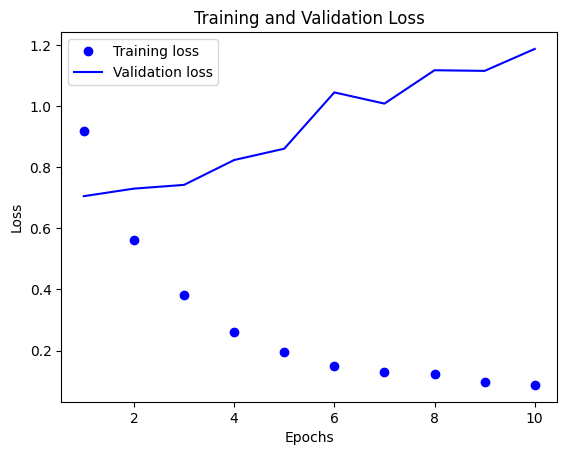

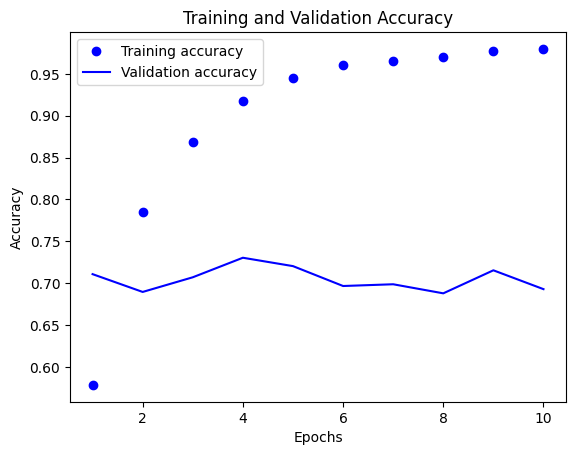

In [35]:
# Epoch별 train data와 test data의 loss와 accuracy 그래프 그리기
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, train_accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [36]:
from tensorflow.keras.layers import GRU

# GRU 모델 구축
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_length))
model.add(Bidirectional(GRU(128, return_sequences=True, recurrent_dropout=0.2)))
model.add(Bidirectional(GRU(128, recurrent_dropout=0.2)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 100)           2058600   
                                                                 
 bidirectional_3 (Bidirectio  (None, 60, 256)          176640    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 256)              296448    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 771       
                                                                 
Total params: 2,532,459
Trainable params: 2,532,459
No

In [37]:
# 모델 훈련
history = model.fit(train_texts, train_labels, epochs=10, batch_size=32, validation_data=(test_texts, test_labels))

Epoch 1/10
300/300 [==============================] - 230s 741ms/step - loss: 0.8134 - accuracy: 0.6427 - val_loss: 0.6779 - val_accuracy: 0.7250
Epoch 2/10
300/300 [==============================] - 221s 736ms/step - loss: 0.4523 - accuracy: 0.8240 - val_loss: 0.6703 - val_accuracy: 0.7317
Epoch 3/10
300/300 [==============================] - 219s 729ms/step - loss: 0.2523 - accuracy: 0.9082 - val_loss: 0.7589 - val_accuracy: 0.7325
Epoch 4/10
300/300 [==============================] - 217s 723ms/step - loss: 0.1358 - accuracy: 0.9575 - val_loss: 0.9268 - val_accuracy: 0.7233
Epoch 5/10
300/300 [==============================] - 219s 732ms/step - loss: 0.0842 - accuracy: 0.9744 - val_loss: 1.0860 - val_accuracy: 0.7167
Epoch 6/10
300/300 [==============================] - 218s 727ms/step - loss: 0.0658 - accuracy: 0.9789 - val_loss: 1.1620 - val_accuracy: 0.7083
Epoch 7/10
300/300 [==============================] - 219s 732ms/step - loss: 0.0511 - accuracy: 0.9848 - val_loss: 1.2831 -

In [38]:
# 테스트 데이터로 성능 측정
predictions = model.predict(test_texts)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(test_labels, axis=1)

print(classification_report(true_labels, predicted_labels))

75/75 [==============================] - 9s 109ms/step
              precision    recall  f1-score   support

           0       0.51      0.57      0.54       587
           1       0.79      0.67      0.72       733
           2       0.81      0.84      0.83      1080

    accuracy                           0.72      2400
   macro avg       0.70      0.69      0.70      2400
weighted avg       0.73      0.72      0.72      2400



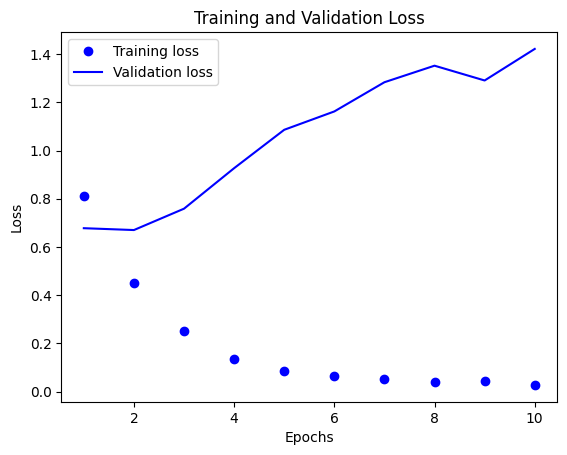

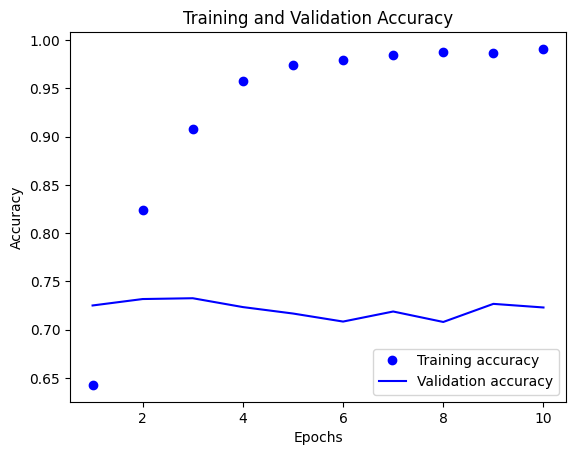

In [39]:
# Epoch별 train data와 test data의 loss와 accuracy 그래프 그리기
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, train_accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()